In [1]:
import os
import torch
from torchinfo import summary
from pathlib import Path
import torch.nn as nn

## Create Vision Transformer (ViT)

In [2]:
from melanoma_classification import VisionTransformer

In [3]:
vit = VisionTransformer()
vit.load_pretrained_weights('deit_base_patch16_224')
# vit.set_classifier(num_classes=2)

Using cache found in C:\Users\Qunor/.cache\torch\hub\facebookresearch_deit_main
c:\Users\Qunor\.pyenv-win-venv\envs\melanoma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Qunor\.pyenv-win-venv\envs\melanoma\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\Qunor\.pyenv-win-venv\envs\melanoma\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
C:\Users\Qunor/.cache\torch\hub\facebookresearch_deit_main\mod

In [4]:
classifier = nn.Sequential(
    nn.Linear(vit.get_embedding_dimension(), 64),
    nn.ReLU(),
    nn.Linear(64, 2)
)
vit.classifier = classifier

## Prepare data

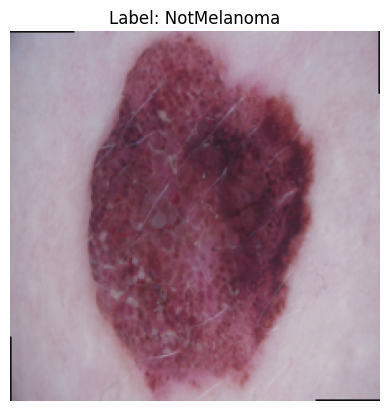

In [5]:
from utils.dermmel import DermMel
from melanoma_classification.utils.transformations import (
    train_transform,
    production_transform
)

train_dataset = DermMel(
    '../data',
    split='train_sep',
    transform=train_transform()
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

valid_dataset = DermMel(
    '../data',
    split='valid',
    transform=production_transform()
)
valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

train_dataset.visualize_image(-1)

## Training

In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([
    {'params': vit.cls_token, 'lr': 1e-7},
    {'params': vit.pos_embed, 'lr': 1e-7},
    {'params': vit.patch_embedding.parameters(), 'lr': 1e-6},
    {'params': vit.transformer_layers.parameters(), 'lr': 1e-5},
    {'params': vit.norm.parameters(), 'lr': 1e-6},
    {'params': vit.classifier.parameters(), 'lr': 1e-4}
])
# optimizer = torch.optim.AdamW(vit.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

In [7]:
# Init device
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.mps.is_available():
    device = torch.device('mps')

In [8]:
from training.trainer import train

train(
    model=vit,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=20,
    freezed_epochs=5,
    device=device,
    # checkpoint_model_file="checkpoint_epoch_6.pth",
    checkpoint_path=Path("checkpoints/dermmel2"),
    save_every_n_epochs=1
)

Epoch 1/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.99batch/s, val_accuracy=64.8, val_loss=0.0752]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_1.pth


Epoch 2/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.78batch/s, val_accuracy=71.2, val_loss=0.0694]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_2.pth


Epoch 3/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.73batch/s, val_accuracy=67, val_loss=0.0726]  


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_3.pth


Epoch 4/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.69batch/s, val_accuracy=71.6, val_loss=0.0674]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_4.pth


Epoch 5/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 17.06batch/s, val_accuracy=72.9, val_loss=0.0664]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_5.pth
Unfroze norm.
Unfroze layer of transformers.


Epoch 6/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.72batch/s, val_accuracy=74.5, val_loss=0.0654]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_6.pth
Unfroze layer of transformers.
Unfroze layer of transformers.


Epoch 7/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.76batch/s, val_accuracy=63.8, val_loss=0.0876]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_7.pth
Unfroze layer of transformers.
Unfroze layer of transformers.


Epoch 8/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.78batch/s, val_accuracy=72, val_loss=0.0663]  


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_8.pth
Unfroze layer of transformers.
Unfroze layer of transformers.


Epoch 9/20 [Validation]: 100%|██████████| 446/446 [00:25<00:00, 17.17batch/s, val_accuracy=72.1, val_loss=0.0668]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_9.pth
Unfroze layer of transformers.
Unfroze layer of transformers.


Epoch 10/20 [Validation]: 100%|██████████| 446/446 [00:27<00:00, 16.51batch/s, val_accuracy=76.4, val_loss=0.0612]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_10.pth
Unfroze layer of transformers.
Unfroze layer of transformers.


Epoch 11/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.70batch/s, val_accuracy=66.5, val_loss=0.0826]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_11.pth
Unfroze layer of transformers.
Unfroze positional embedding.


Epoch 12/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.79batch/s, val_accuracy=74.4, val_loss=0.0653]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_12.pth
Unfroze cls_token.
Unfroze patch_embedding.


Epoch 13/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.61batch/s, val_accuracy=79, val_loss=0.0561]  


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_13.pth


Epoch 14/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.65batch/s, val_accuracy=75.5, val_loss=0.0623]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_14.pth


Epoch 15/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.58batch/s, val_accuracy=77.6, val_loss=0.0606]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_15.pth


Epoch 16/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.71batch/s, val_accuracy=80.1, val_loss=0.0547]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_16.pth


Epoch 17/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.56batch/s, val_accuracy=74.5, val_loss=0.0736]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_17.pth


Epoch 18/20 [Validation]: 100%|██████████| 446/446 [00:31<00:00, 14.29batch/s, val_accuracy=76.8, val_loss=0.0609]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_18.pth


Epoch 19/20 [Validation]: 100%|██████████| 446/446 [00:26<00:00, 16.59batch/s, val_accuracy=79.7, val_loss=0.0547]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_19.pth


Epoch 20/20 [Validation]: 100%|██████████| 446/446 [00:27<00:00, 16.35batch/s, val_accuracy=80.4, val_loss=0.0533]


Checkpoint saved: checkpoints\dermmel2\checkpoint_epoch_20.pth
